In [19]:
import os
import glob

import pandas as pd
import numpy as np
import seaborn as sns
sns.set_context("notebook")
import matplotlib.pyplot as plt

import datetime
import time

import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

import plotly.express as px
import plotly.graph_objects as go

# models
from sklearn.cluster import KMeans # centroid-based
from sklearn.cluster import DBSCAN # density-based
from sklearn.cluster import Birch # hierarchical

# scaler
from sklearn.preprocessing import RobustScaler

# evaluation metrics
from sklearn.metrics import silhouette_score, davies_bouldin_score

# **3. Modeling**

In [2]:
master_data = pd.read_csv("../data/processed/master_data.csv", engine="pyarrow")
# filter dates until 2018-08 only
master_data = master_data[~master_data["order_purchase_timestamp"].dt.strftime('%Y-%m').isin(["2018-09", "2018-10"])]
master_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 107835 entries, 0 to 107834
Data columns (total 24 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_unique_id             107835 non-null  object        
 1   customer_id                    107835 non-null  object        
 2   customer_zip_code_prefix       107835 non-null  int64         
 3   customer_city                  107835 non-null  object        
 4   customer_state_code            107835 non-null  object        
 5   customer_state                 107835 non-null  object        
 6   order_id                       107835 non-null  object        
 7   order_status                   107835 non-null  object        
 8   order_purchase_timestamp       107835 non-null  datetime64[ns]
 9   order_approved_at              107693 non-null  datetime64[ns]
 10  order_delivered_carrier_date   105949 non-null  datetime64[ns]
 11  order

Pemodelan segmentasi customer difokuskan pada tiga fitur yaitu Recency, Frequency, dan Monetary (RFM). Recency merujuk kepada waktu terakhir customer melakukan transaksi. Frequency adalah seberapa sering customer melakukan transaksi dan monetary adalah pengeluaran customer untuk seluruh transaksi yang dilakukan. Ketiga fitur ini sederhana, intuitif, dan mudah diinterprasikan. RFM sudah cukup merepresentasikan perilaku customer untuk bisa dibuat segmentasi.

Keluaran dari segmentasi ini adalah mendapatkan actionable plan yang dapat meningkatkan retensi customer berdasarkan segmennya. Ada dua pemodelan yang akan dilakukan yaitu dengan clustering atau unsupervised machine learning, dan RFM analysis. Beberapa hal yang akan dipertimbangkan dalam pemodelan adalah: metrik evaluasi, waktu pemrosesan, dan interpretasi (baik secara visual maupun eksplorasi data segmen lebih lanjut).

## **3.1 RFM Features**

Langkah pertama yang akan dilakukan adalah membuat fitur RFM untuk setiap customer_unique_id.

In [3]:
# drop duplicates in payment_sequential due to different product_id
customer_activity = master_data.drop_duplicates(subset=["customer_unique_id", "order_id", "order_purchase_timestamp", "payment_sequential", "payment_value"], keep='first', ignore_index=True)

# aggregate sum of payment_value with different payment_sequential
customer_activity = customer_activity.groupby(["customer_unique_id", "order_id", "order_purchase_timestamp"], as_index=False).agg(
    payment_value = ("payment_value", "sum")
).sort_values(by=["order_purchase_timestamp", "order_id"], ignore_index=True)

In [4]:
# get current date, assumption is one day after last order_purchase_timestamp
max_date = customer_activity["order_purchase_timestamp"].max() + datetime.timedelta(1)

# create recency, frequency, monetary per customer_unique_id
rfm_data = customer_activity.groupby("customer_unique_id", as_index=False).agg(
    recency =  ("order_purchase_timestamp", lambda x: (max_date-x.max()).days),
    frequency = ("order_id", lambda x: x.nunique()),
    monetary =  ("payment_value", "sum")
)

display(rfm_data.describe().T, rfm_data.tail())

count        mean         std  min     25%    50%       75%  \
recency    96090.0  241.672089  153.400070  1.0  117.00  222.0  351.0000   
frequency  96090.0    1.034665    0.213879  1.0    1.00    1.0    1.0000   
monetary   96090.0  166.552049  231.324551  0.0   63.12  108.0  183.5175   

                max  
recency      726.00  
frequency     17.00  
monetary   13664.08

customer_unique_id  recency  frequency  monetary
96085  fffcf5a5ff07b0908bd4e2dbc735a684      449          1   2067.42
96086  fffea47cd6d3cc0a88bd621562a9d061      264          1     84.58
96087  ffff371b4d645b6ecea244b27531430a      571          1    112.46
96088  ffff5962728ec6157033ef9805bacc48      122          1    133.69
96089  ffffd2657e2aad2907e67c3e9daecbeb      486          1     71.56

Terdapat 96090 customer_unique_id dengan rentang data yang bervariasi karena adanya outlier (jarak antara nilai tengah masing-masing fitur cukup jauh dengan nilai maksimumnya). Outlier adalah data yang nilainya berbeda secara signifikan terhadap ukuran pemusatan data (misal rerata atau nilai tengah). Outlier perlu ditangani mengingat algoritma clustering umumnya mempertimbangkan jarak dalam prosesnya, sehingga ketika ada outlier, segmentasi menjadi kurang presisi. Akan tetapi, di sini sebisa mungkin data akan dipertahankan sesuai dengan kondisi aslinya agar tetap representatif ketika melakukan interpretasi segmen. Penanganan outlier hanya dilakukan untuk data yang akan digunakan pada pemodelan machine learning.

## **3.2 ML Modeling**

### **3.2.1 Outliers**

Langkah selanjutnya adalah mendeteksi outlier khususnya pada fitur yang bersifat numerik dan kontinu yaitu Recency dan Monetary. Dari statistik deskriptif juga sudah bisa terlihat adanya outlier pada fitur Frequency yang bersifat diskrit numerik. Deteksi dan penanganan outlier difokuskan pada fitur Recency dan Monetary terlebih dulu karena mungkin saja outlier pada kedua fitur ini juga merupakan outlier di fitur Frequency. Deteksi outlier akan menggunakan metode IQR (interquartile range).

In [5]:
def detect_iqr_bounds(data):
    q1, q3 = np.percentile(data, 25), np.percentile(data, 75)
    iqr = q3 - q1
    lower, upper = q1 - (1.5 * iqr), q3 + (1.5 * iqr)
    return round(lower,2), round(upper,2)

In [6]:
iqr_outliers = pd.DataFrame(columns=["variable", "method", "lower_threshold", "upper_threshold", "n_outlier", "pct_outlier"])
for col in ["recency", "monetary"]:
    lower, upper = detect_iqr_bounds(rfm_data[col])
    n_outlier = len(rfm_data[(rfm_data[col] > upper) | (rfm_data[col] < lower)])
    pct_outlier = round(n_outlier/len(rfm_data)*100,2)
    method = "iqr"
    iqr_outliers.loc[len(iqr_outliers)] = [col, method, lower, upper, n_outlier, pct_outlier]
iqr_outliers

variable method  lower_threshold  upper_threshold  n_outlier  pct_outlier
0   recency    iqr          -234.00           702.00          4         0.00
1  monetary    iqr          -117.48           364.11       7650         7.96

In [7]:
rfm_data[rfm_data["recency"] > 702]

customer_unique_id  recency  frequency  monetary
238    009b0127b727ab0ba422f6d9604487c7      718          1     40.95
27243  4854e9b3feff728c13ee5fc7d1547e92      726          1     75.06
49310  830d5b7aaa3b6f1e9ad63703bec97d23      716          1    143.46
69092  b7d76e111c89f7ebf14761390f0f7d17      726          1    136.23

Dengan metode IQR, hanya terdapat 4 poin data yang merupakan outlier secara Recency (tetapi bukan outlier secara Monetary). Namun, outlier secara Monetary cukup tinggi (hampir 8% dari keseluruhan data) yang akan dipisahkan menjadi satu cluster tersendiri dan tidak digunakan dalam pemodelan.

In [8]:
_, monetary_upper_thres = detect_iqr_bounds(rfm_data["monetary"])

rfm_data_clean = rfm_data[rfm_data["monetary"] <= monetary_upper_thres].copy()
rfm_data_clean.reset_index(inplace=True, drop=True)

display(rfm_data_clean.describe().T, rfm_data_clean.tail())

count        mean         std  min     25%     50%     75%    max
recency    88440.0  241.704692  153.190237  1.0  118.00  223.00  351.00  726.0
frequency  88440.0    1.026888    0.171595  1.0    1.00    1.00    1.00    6.0
monetary   88440.0  118.823089   75.708569  0.0   60.08   99.74  160.21  364.1

customer_unique_id  recency  frequency  monetary
88435  fffbf87b7a1a6fa8b03f081c5f51a201      247          1    167.32
88436  fffea47cd6d3cc0a88bd621562a9d061      264          1     84.58
88437  ffff371b4d645b6ecea244b27531430a      571          1    112.46
88438  ffff5962728ec6157033ef9805bacc48      122          1    133.69
88439  ffffd2657e2aad2907e67c3e9daecbeb      486          1     71.56

Jumlah data tanpa adanya outlier secara Monetary yang akan digunakan dalam pemodelan adalah 88440 poin data.

### **3.2.2 Feature Engineering**

#### **Scaler**

Hal lain yang perlu diperhatikan dalam pemodelan khususnya clustering adalah skala dari fitur karena perhitungan jarak menjadi kurang berarti ketika fitur tidak berada pada rentang nilai yang mirip. Penskalaan fitur akan dilakukan menggunakan Robust Scaler dengan cara mengurangi fitur dengan nilai mediannya kemudian diskala ulang berdasarkan IQRnya (iqr = q3 - q1).

In [9]:
scaler = RobustScaler()

rfm_scaled = scaler.fit_transform(rfm_data_clean[["recency", "frequency", "monetary"]])
rfm_scaled_data = pd.DataFrame(rfm_scaled)
rfm_scaled_data.columns = ["recency_", "frequency", "monetary"]
display(rfm_scaled_data.describe().T, rfm_scaled_data.tail())

count      mean       std       min       25%  50%       75%  \
recency_   88440.0  0.080278  0.657469 -0.952790 -0.450644  0.0  0.549356   
frequency  88440.0  0.026888  0.171595  0.000000  0.000000  0.0  0.000000   
monetary   88440.0  0.190583  0.756103 -0.996105 -0.396085  0.0  0.603915   

                max  
recency_   2.158798  
frequency  5.000000  
monetary   2.640168

recency_  frequency  monetary
88435  0.103004        0.0  0.674923
88436  0.175966        0.0 -0.151403
88437  1.493562        0.0  0.127035
88438 -0.433476        0.0  0.339059
88439  1.128755        0.0 -0.281434

Terlihat bahwa ketiga fitur setelah dilakukan penskalaan mempunyai nilai rentang yang tidak berbeda jauh.

### **3.2.3 Benchmark Model**

Algoritma clustering dapat dikelompokkan berdasarkan basis cara kerjanya, beberapa di antaranya adalah: algoritma berbasis centroid, density, dan hierarchy. Tiga model dari masing-masing jenis algoritma digunakan untuk melakukan benchmark model yaitu K-Means, DBSCAN, dan BIRCH. Pertimbangan memilih ketiga model ini adalah skalabilitas algoritma terhadap jumlah data, mengingat data yang digunakan cukup besar (hampir 90 ribu baris data). Benchmark model akan mengevaluasi metrik (Silhouette score dan Davis Bouldin score) dan waktu komputasi.

In [10]:
def run_benchmark(benchmark_flag=False):
    if not benchmark_flag:
        benchmark_data = pd.read_csv("../data/model/benchmark_data.csv")

    else:
        kmeans = KMeans(n_clusters=4, random_state=0)
        dbscan = DBSCAN(eps=0.5, min_samples=5, n_jobs=-1)
        birch = Birch(n_clusters=4, threshold=0.5, branching_factor=50)

        metrics = []
        model = {
            "K-Means": kmeans,
            "DBSCAN": dbscan,
            "BIRCH" : birch
        }

        for name, estimator in model.items():
            print(f"training model {name}")
            
            start = time.time()
            result = estimator.fit_predict(rfm_scaled)
            fit_time = time.time() - start
            
            start = time.time()
            silhouette = silhouette_score(rfm_scaled, result)
            silhouette_time = time.time() - start
            
            start = time.time()
            davies = davies_bouldin_score(rfm_scaled, result)
            davies_time = time.time() - start
            
            metrics.append({
                "model" : name,
                "silhouette_score": silhouette,
                "davies_bouldin_score": davies,
                "n_cluster": len(np.unique(result)),
                "fit_time_seconds": fit_time,
                "silhouette_score_time_seconds": silhouette_time,
                "davies_score_time_seconds": davies_time
            })
                
        benchmark_data = pd.DataFrame(metrics)
        benchmark_data.to_csv("../data/model/benchmark_data.csv", index=False)
    
    PROPS = "color:#000000;font-weight:bold;background-color:#FFFF00"
    return benchmark_data.style.\
            highlight_min(subset=["davies_bouldin_score", "fit_time_seconds"], props=PROPS).\
            highlight_max(subset=["silhouette_score"], props=PROPS)

In [11]:
# set benchmark = True to run benchmark
benchmark_flag = True
run_benchmark(benchmark_flag)

training model K-Means


training model DBSCAN
training model BIRCH


Secara metrik evaluasi, BIRCH memiliki performa terbaik (Silhouette score paling tinggi dan Davis Bouldin score terendah) meskipun waktu trainingnya ~3-4x lebih lama daripada K-Means. DBSCAN memiliki waktu komputasi paling lama, bisa lebih 100x lebih lama dari dua model lainnya. Model BIRCH dan K-Means akan dicoba tuning lebih lanjut untuk melihat apakah performa model masih dapat ditingkatkan.

### **3.2.4 Tuning K-Means**

K-Means merupakan algoritma clustering berbasis centroid dengan cara kerja:
1. Menentukan nilai k jumlah cluster
2. Inisialisasi awal centroid sebanyak k poin data secara acak
3. Mengelompokkan semua poin data berdasarkan jarak (umumnya euclidean) antara titik tersebut dengan setiap centroid. Poin data akan dikelompokkan menjadi satu cluster dengan centroid yang memiliki jarak terdekat. Centroid kemudian dihitung ulang dengan merata-ratakan nilai poin data dalam sebuah cluster yang sama.
4. Melakukan iterasi langkah ke-3 sampai nilai centroid tidak lagi berubah secara signifikan (lebih kecil dari threshold tertentu atau nilai centroid baru sama dengan nilai centroid sebelumnya)

#### **Tune**

Parameter yang dapat dituning untuk K-Means adalah jumlah cluster yang ingin dibentuk. Evaluasi akan dilakukan secara grafis dengan melihat perbandingan jumlah cluster yang digunakan terhadap Silhouette score dan Davies Bouldin score.

In [16]:
def run_kmeans_tuning(kmeans_tuning_flag=False):
    if not kmeans_tuning_flag:
        kmeans_tuning_data = pd.read_csv("../data/model/kmeans_tuning.csv")
    
    else:
        n_clusters = list(range(2,13))
        kmeans_tuning = []

        for n_clust in n_clusters:
            print(f"cluster = {n_clust}", end="\r")
            model = KMeans(n_clusters=n_clust,
                            max_iter=300,
                            init="k-means++",
                            n_init=1,
                            tol=1e-4,
                            algorithm="lloyd",
                            random_state=0)
            result = model.fit_predict(rfm_scaled)
            
            silhouette = silhouette_score(rfm_scaled, result, metric="euclidean")
            davies = davies_bouldin_score(rfm_scaled, result)
            
            kmeans_tuning.append({
                "clusters": n_clust,
                "silhouette_score": silhouette,
                "davies_bouldin_score": davies,
                "inertia": model.inertia_
            })
        
        kmeans_tuning_data = pd.DataFrame(kmeans_tuning)
        # save tuning data for later visualization
        kmeans_tuning_data.to_csv("../data/model/kmeans_tuning.csv", index=False)

    return kmeans_tuning_data

In [17]:
# set kmeans_tuning_flag = True to run k-means tuning
kmeans_tuning_flag = True
kmeans_tuning_data = run_kmeans_tuning(kmeans_tuning_flag)

#### **Visualize Metrics**

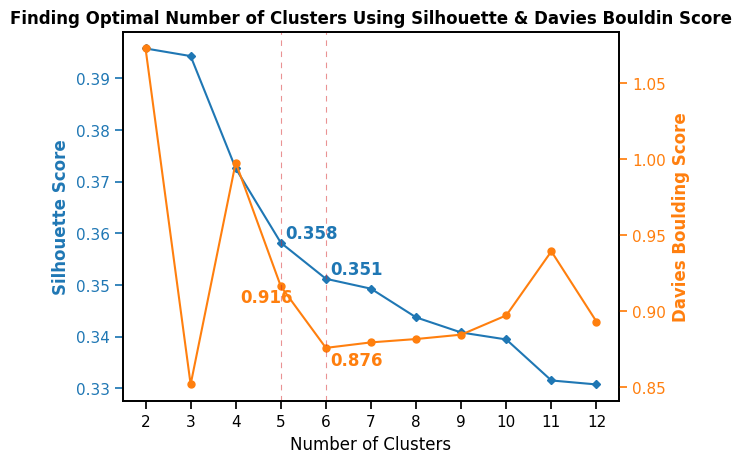

In [23]:
fig, ax = plt.subplots()
ax.plot(kmeans_tuning_data["clusters"], kmeans_tuning_data["silhouette_score"], color="C0", marker="D", ms=4)
ax2 = ax.twinx()
ax2.plot(kmeans_tuning_data["clusters"], kmeans_tuning_data["davies_bouldin_score"], color="C1", marker="o", ms=5)

ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")

ax.set_ylabel('Silhouette Score', color='C0', weight='bold')
ax2.set_ylabel('Davies Boulding Score', color='C1', weight='bold')

plt.axvline(x=5, linestyle=(0,(5,5)), color='C3', linewidth=0.8, alpha=0.5)
plt.axvline(x=6, linestyle=(0,(5,5)), color='C3', linewidth=0.8, alpha=0.5)

y_sil = round(kmeans_tuning_data[kmeans_tuning_data["clusters"]==5]["silhouette_score"].values[0],3)
ax.annotate(str(y_sil), xy=(5+0.1,y_sil+0.001), weight='bold', color='C0')

y_dav = round(kmeans_tuning_data[kmeans_tuning_data["clusters"]==5]["davies_bouldin_score"].values[0],3)
ax2.annotate(str(y_dav), xy=(5-0.9,y_dav-0.01), weight='bold', color='C1')

y_sil = round(kmeans_tuning_data[kmeans_tuning_data["clusters"]==6]["silhouette_score"].values[0],3)
ax.annotate(str(y_sil), xy=(6+0.1,y_sil+0.001), weight='bold', color='C0')

y_dav = round(kmeans_tuning_data[kmeans_tuning_data["clusters"]==6]["davies_bouldin_score"].values[0],3)
ax2.annotate(str(y_dav), xy=(6+0.1,y_dav-0.012), weight='bold', color='C1')

plt.xticks(list(range(2,13)))
ax.set_xlabel('Number of Clusters')
plt.title('Finding Optimal Number of Clusters Using Silhouette & Davies Bouldin Score', weight='bold')
plt.show()

Dari grafik di atas, kemungkinan jumlah cluster yang dapat memberikan nilai metrik evaluasi yang optimal adalah 5 atau 6. Perlu diperhatikan bahwa skala untuk Silhouette score (warna biru) dan Davies Bouldin score (warna oranye) pada grafik di atas berbeda (dua ticks sumbu y warna biru berjarak 0.01 dan warna oranye berjarak 0.05). Pada akhirnya, jumlah cluster yang dipilih untuk dievaluasi lebih lanjut secara visualisasi adalah 6 (Silhouette score tidak berbeda jauh dari jumlah cluster 5 tetapi Davies Bouldin scorenya lebih rendah).

#### **Visualize Clusters**

In [24]:
model = KMeans(
    n_clusters=6,
    random_state=0)
model.fit_predict(rfm_scaled)

kmeans_segmentation = rfm_data_clean.copy()
kmeans_segmentation["clusters"] = model.labels_

In [25]:
def plot_rfm_segmentation(data, hue=None, size=None, size_order=None, hue_order=None):
    if not hue:
        hue = 'clusters'

    if not size:
        size = 'clusters'

    if not size_order:
        size_order = data["clusters"]
    
    if not hue_order:
        hue_order = data["clusters"]

    plt.figure(figsize=(24,8), facecolor='w')
    plt.subplot(131)
    sns.scatterplot(x='recency', 
                    y='frequency', 
                    hue=hue, 
                    data=data, 
                    size=size, 
                    sizes=(50,150), 
                    size_order=size_order, 
                    hue_order=hue_order, 
                    palette='Spectral')
    plt.title('Customer Segment by Recency & Frequency',fontsize=16)
    plt.xlabel('Recency',fontsize=14)
    plt.ylabel('Frequency',fontsize=14)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    plt.subplot(132)
    sns.scatterplot(x='recency', 
                    y='monetary', 
                    hue=hue, 
                    data=data, 
                    size=size, 
                    sizes=(50,150), 
                    size_order=size_order,
                    hue_order=hue_order, 
                    palette='Spectral')
    plt.title('Customer Segment by Recency & Monetary',fontsize=16)
    plt.xlabel('Recency',fontsize=14)
    plt.ylabel('Monetary',fontsize=14)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    plt.subplot(133)
    sns.scatterplot(x='frequency', 
                    y='monetary', 
                    hue=hue, 
                    data=data, 
                    size=size, 
                    sizes=(50,150), 
                    size_order=size_order,
                    hue_order=hue_order,
                    palette='Spectral')
    plt.title('Customer Segment by Frequency & Monetary',fontsize=16)
    plt.xlabel('Frequency',fontsize=14)
    plt.ylabel('Monetary',fontsize=14)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    plt.tight_layout()
    plt.show()

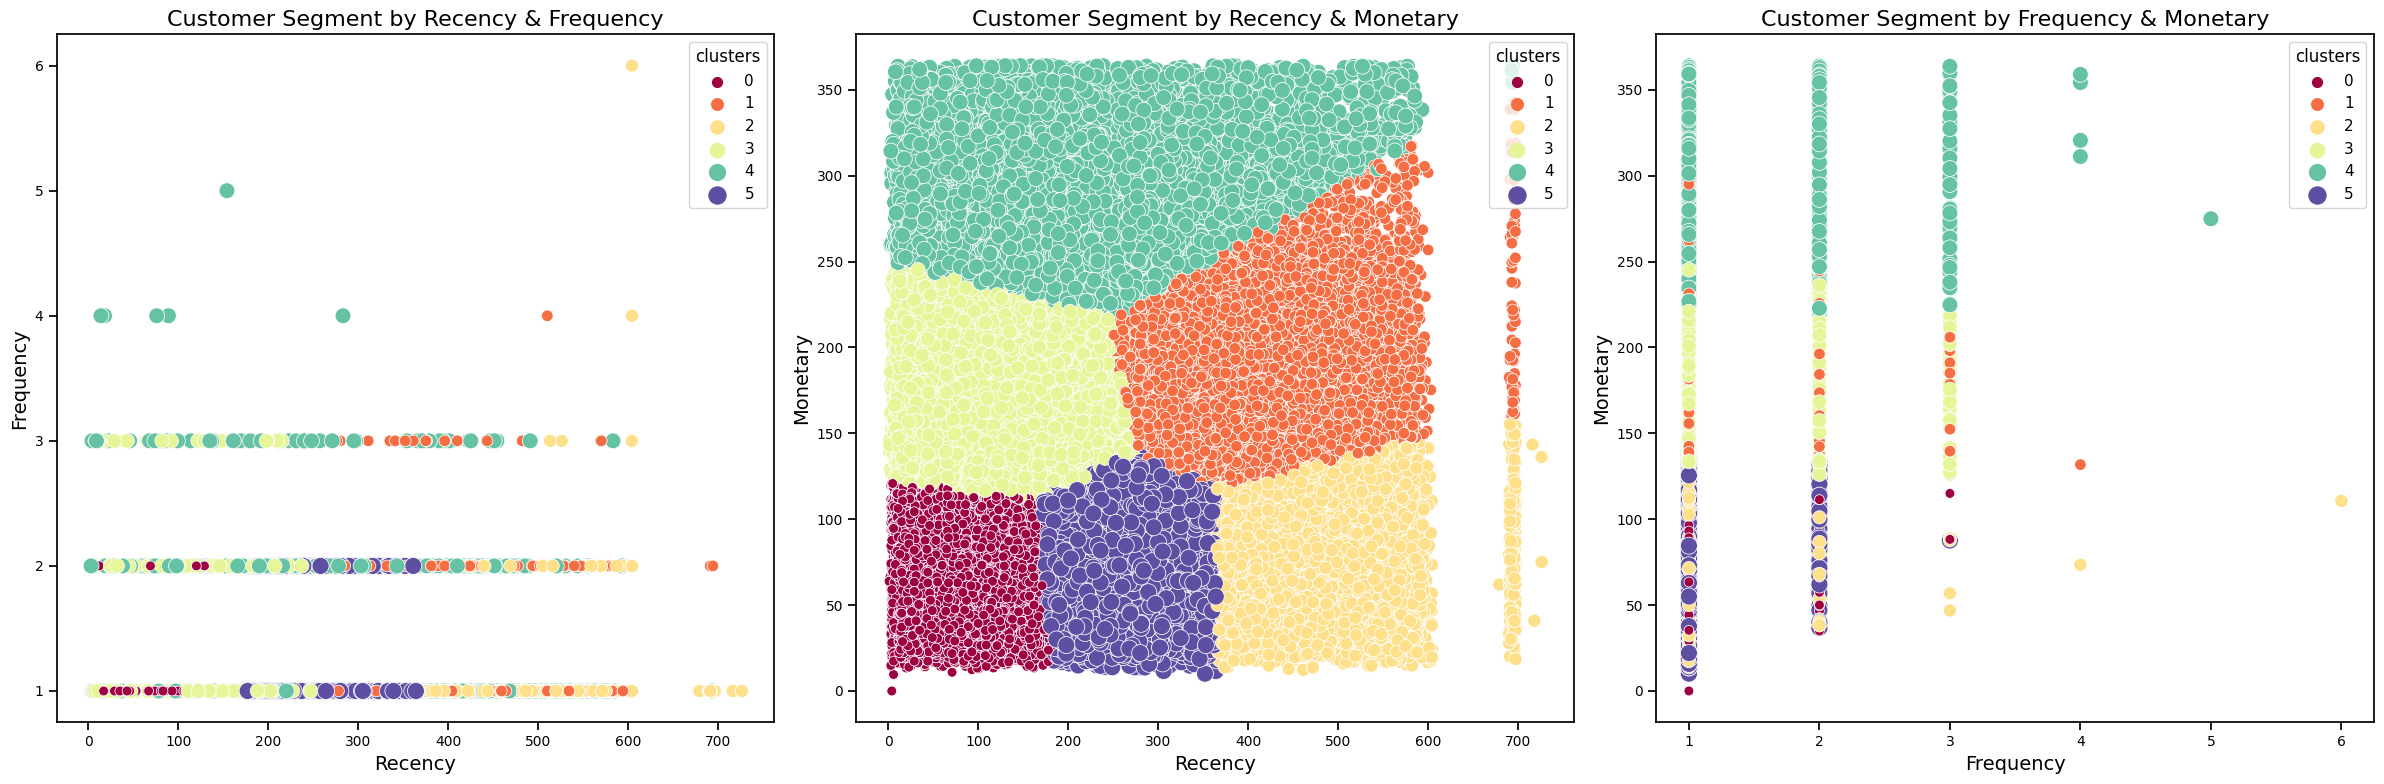

In [26]:
plot_rfm_segmentation(kmeans_segmentation)

Dari hasil visualisasi, K-Means berhasil melakukan segmentasi yang terpisah cukup jelas secara Recency dan Monetary (grafik di tengah). Tetapi, K-Means tidak bisa membedakan segmen berdasarkan frekuensinya dan cenderung tidak ada segmen terpisah untuk frekuensi yang besar.

### **3.2.5 Tuning BIRCH**

BIRCH atau Balanced Iterative Reducing & Clustering using Hierarchy merupakan algoritma clustering berbasis hierarchy atau struktur pohon.

Ada dua pendekatan untuk membangun pohon hierarchy berdasarkan arahnya yaitu top-down (divisive clustering) atau bottom-up (agglomerative clustering). Pendekatan top-down mempunyai tingkat kesulitan pada penentuan kriteria splitting dan cluster mana pada kedalaman tertentu yang perlu displit lebih lanjut. Sementara itu, pendekatan bottom-up mempunyai kekurangan utama tidak scalable pada dataset besar karena perlunya perhitungan jarak antara semua pasangan poin data untuk melakukan clustering.

Beberapa terminologi yang perlu diperhatikan untuk algoritma BIRCH:
* Clustering Feature (CF), yaitu rangkuman informasi sebuah cluster (n, LS, LSS, centroid) yang terdiri dari: 
    * n, banyaknya sample
    * LS, jumlah seluruh nilai sample
    * LSS, jumlah kuadrat seluruh nilai sample
    * centroid, didapat dari LS/N
* Threshold, batas radius untuk pengelompokan sample ke cluster terdekat
* Branching Factor, maksimal jumlah cluster pada satu node

Algoritma BIRCH terdiri dari dua tahap:
* Tahap 1 atau micro-clustering, di mana setiap poin data dikelompokkan ke cluster node leaf berdasarkan kedekatan nilainya terhadap centroid di node tersebut. Jika radius cluster setelah penambahan poin data menjadi lebih besar dari threshold, maka node leaf akan displit. Informasi mengenai poin data baru kemudian diperbarui sampai ke root pohon untuk digunakan ketika menambahkan poin data berikutnya. BIRCH merupakan kombinasi dari pendekatan bottom-up dan top-down karena berangkat dari masing-masing data point yang dikelompokkan ke cluster tertentu (bottom-up) dan cluster yang terbentuk memungkinkan untuk displit kemudian (top-down). 
* Tahap 2 disebut juga macro-clustering atau global clustering, di mana leaf node pada pohon CF hasil dari tahap 1 dikelompokkan lebih lanjut menggunakan metode clustering lain yang terpilih (untuk implementasi library sklearn adalah agglomerative clustering)

#### **Tune**

Parameter yang akan dituning untuk model BIRCH adalah jumlah cluster akhir yang ingin dibentuk dan threshold radius dari sebuah Clustering Feature node. Semakin besar threshold radius, jumlah cluster yang terbentuk (pada tahap 1) akan semakin kecil.

In [27]:
def run_birch_tuning(birch_tuning_flag=False):
    if not birch_tuning_flag:
        birch_tuning_data = pd.read_csv("../data/model/birch_tuning.csv")
    
    else:
        n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
        threshold = [0.5, 0.6, 0.7]

        birch_tuning = []

        for n_clust in n_clusters:
            for thres in threshold:
                    print(f"cluster, threshold = {n_clust}, {thres}", end="\r")
                    model = Birch(n_clusters=n_clust, threshold=thres)
                    result = model.fit_predict(rfm_scaled)
                    
                    silhouette = silhouette_score(rfm_scaled, result, metric="euclidean")
                    davies = davies_bouldin_score(rfm_scaled, result)
                    
                    birch_tuning.append({
                        "clusters": n_clust,
                        "threshold": thres,
                        "silhouette_score": silhouette,
                        "davies_bouldin_score": davies
                    })

        birch_tuning_data = pd.DataFrame(birch_tuning)
        birch_tuning_data.to_csv("../data/model/birch_tuning.csv", index=False)
    
    return birch_tuning_data

In [28]:
# set birch_tuning_flag = True to run birch tuning
birch_tuning_flag = True
birch_tuning_data = run_birch_tuning(birch_tuning_flag)

#### **Visualize Metrics**

Ada cukup banyak kombinasi parameter yang bisa dipilih karena ada dua parameter berbeda yang dituning. Hasil tuning akan diurutkan sesuai dengan metriknya (Silhouette score tertinggi dan Davies Bouldin score terendah).

In [29]:
birch_tuning_data[birch_tuning_data["clusters"] > 3].sort_values(by=["silhouette_score", "davies_bouldin_score"], ascending=[False, True], ignore_index=True).head(10)

clusters  threshold  silhouette_score  davies_bouldin_score
0         4        0.5          0.397173              0.824946
1         4        0.7          0.364277              0.862697
2         8        0.7          0.360112              0.789650
3         9        0.7          0.359390              0.796322
4         5        0.6          0.354340              0.914561
5         8        0.5          0.346051              0.796199
6        10        0.7          0.344656              0.770553
7        11        0.7          0.344389              0.768936
8        11        0.5          0.344298              0.860587
9         9        0.5          0.343154              0.827764

Meskipun metrik terbaik didapatkan dari kombinasi jumlah cluster 4 dan threshold 0.5, metrik terbaik selanjutnya paling banyak terjadi ketika threshold sebesar 0.7. Evaluasi metrik secara grafis akan dilanjutkan untuk hasil tuning dengan threshold 0.7.

In [30]:
birch_viz = birch_tuning_data[birch_tuning_data["threshold"]==0.7]

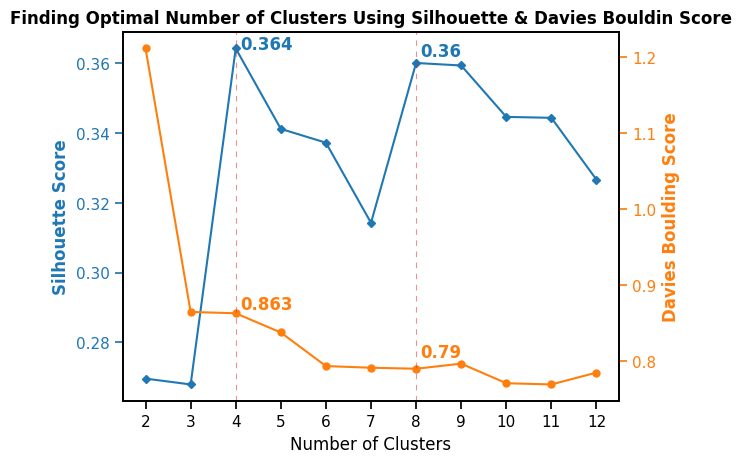

In [31]:
fig, ax = plt.subplots()
ax.plot(birch_viz["clusters"], birch_viz["silhouette_score"], color="C0", marker="D", ms=4)
ax2 = ax.twinx()
ax2.plot(birch_viz["clusters"], birch_viz["davies_bouldin_score"], color="C1", marker="o", ms=5)

ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")

ax.set_ylabel('Silhouette Score', color='C0', weight='bold')
ax2.set_ylabel('Davies Boulding Score', color='C1', weight='bold')

plt.axvline(x=4, linestyle=(0,(5,5)), color='C3', linewidth=0.8, alpha=0.5)
plt.axvline(x=8, linestyle=(0,(5,5)), color='C3', linewidth=0.8, alpha=0.5)

y_sil = round(birch_viz[birch_viz["clusters"]==4]["silhouette_score"].values[0],3)
ax.annotate(str(y_sil), xy=(4+0.1,y_sil+0.0001), weight='bold', color='C0')

y_dav = round(birch_viz[birch_viz["clusters"]==4]["davies_bouldin_score"].values[0],3)
ax2.annotate(str(y_dav), xy=(4+0.1,y_dav+0.005), weight='bold', color='C1')

y_sil = round(birch_viz[birch_viz["clusters"]==8]["silhouette_score"].values[0],3)
ax.annotate(str(y_sil), xy=(8+0.1,y_sil+0.002), weight='bold', color='C0')

y_dav = round(birch_viz[birch_viz["clusters"]==8]["davies_bouldin_score"].values[0],3)
ax2.annotate(str(y_dav), xy=(8+0.1,y_dav+0.015), weight='bold', color='C1')

plt.xticks(list(range(2,13)))
ax.set_xlabel('Number of Clusters')
plt.title('Finding Optimal Number of Clusters Using Silhouette & Davies Bouldin Score', weight='bold')
plt.show()

Dari grafik di atas, jumlah cluster yang memberikan nilai metrik evaluasi paling baik adalah 4 atau 8. Perlu diperhatikan lagi bahwa skala untuk Silhouette score (warna biru) dan Davies Bouldin score (warna oranye) pada grafik di atas berbeda (dua ticks sumbu y warna biru berjarak 0.02 dan warna oranye berjarak 0.1). Jumlah cluster yang dipilih untuk dievaluasi lebih lanjut secara visualisasi adalah 8, selain karena Davies Bouldin scorenya lebih rendah, jumlah cluster 4 juga relatif masih kecil sehingga segmen clustering akan kurang spesifik.

#### **Visualize Clusters**

In [32]:
model = Birch(n_clusters=8, threshold=0.7, branching_factor=50)
model.fit_predict(rfm_scaled)

birch_segmentation = rfm_data_clean.copy()
birch_segmentation["clusters"] = model.labels_

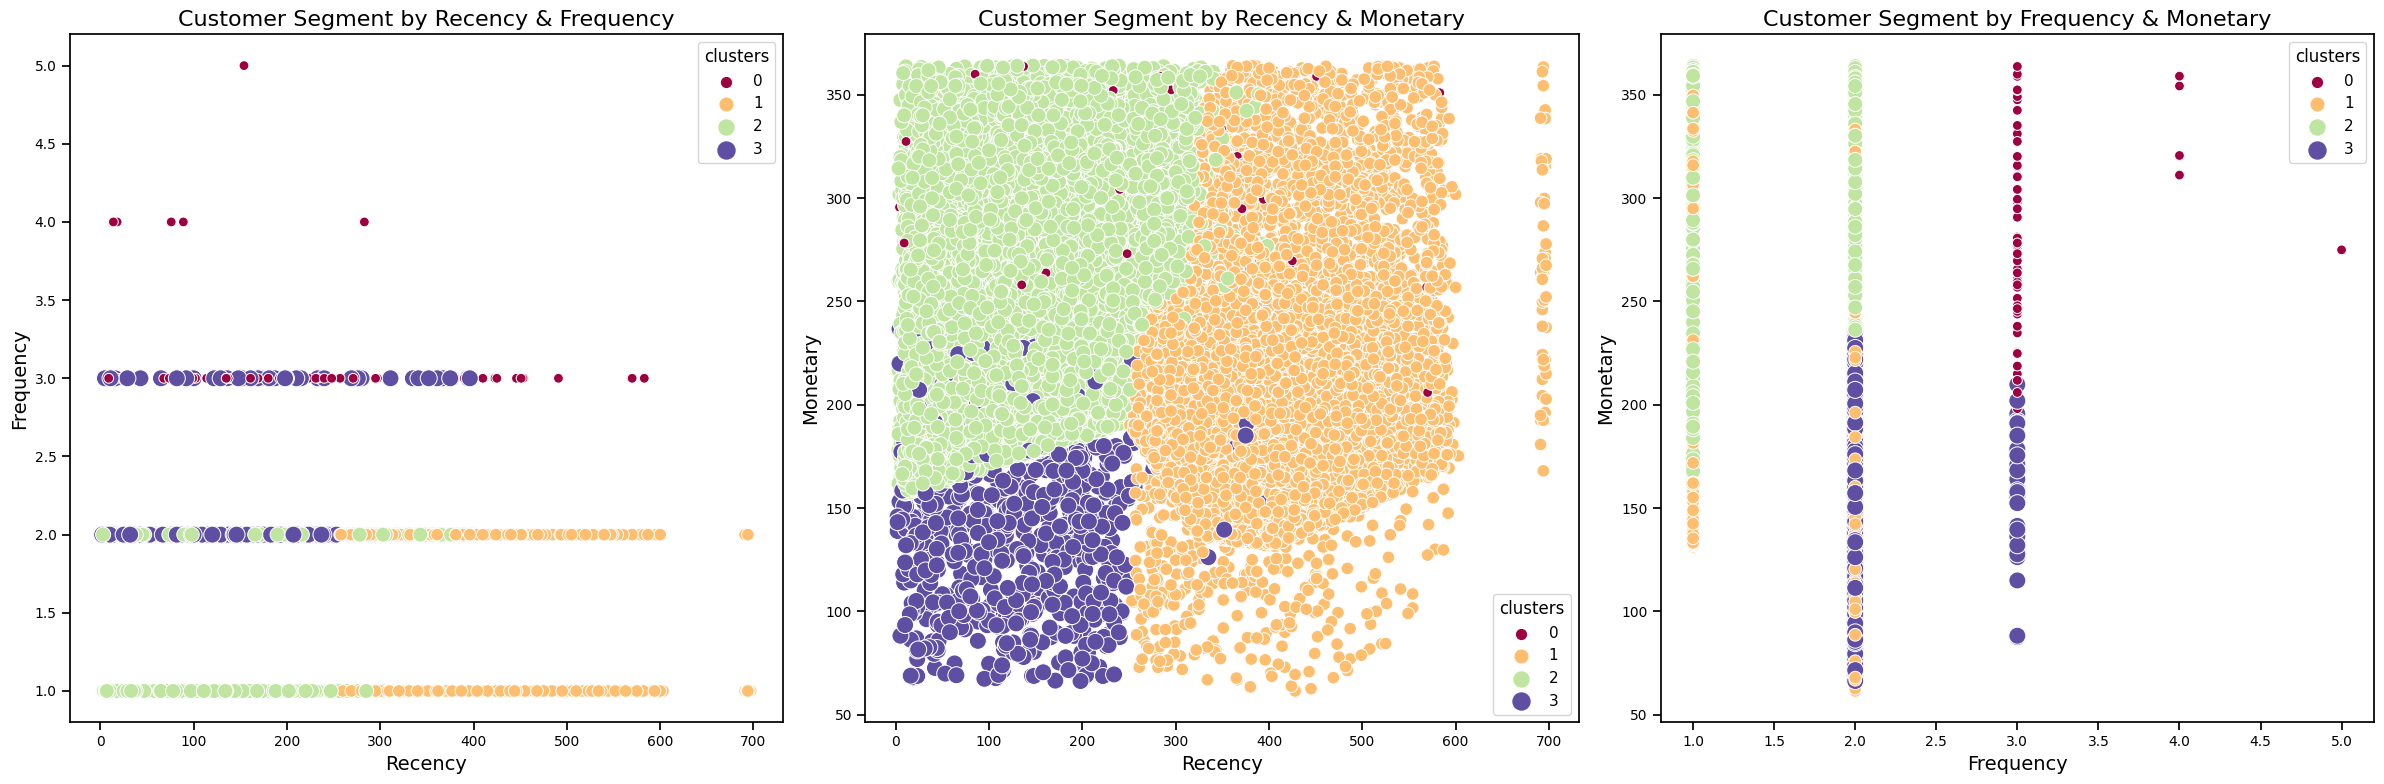

In [35]:
plot_rfm_segmentation(birch_segmentation[birch_segmentation["clusters"].isin([0,1,2,3])])

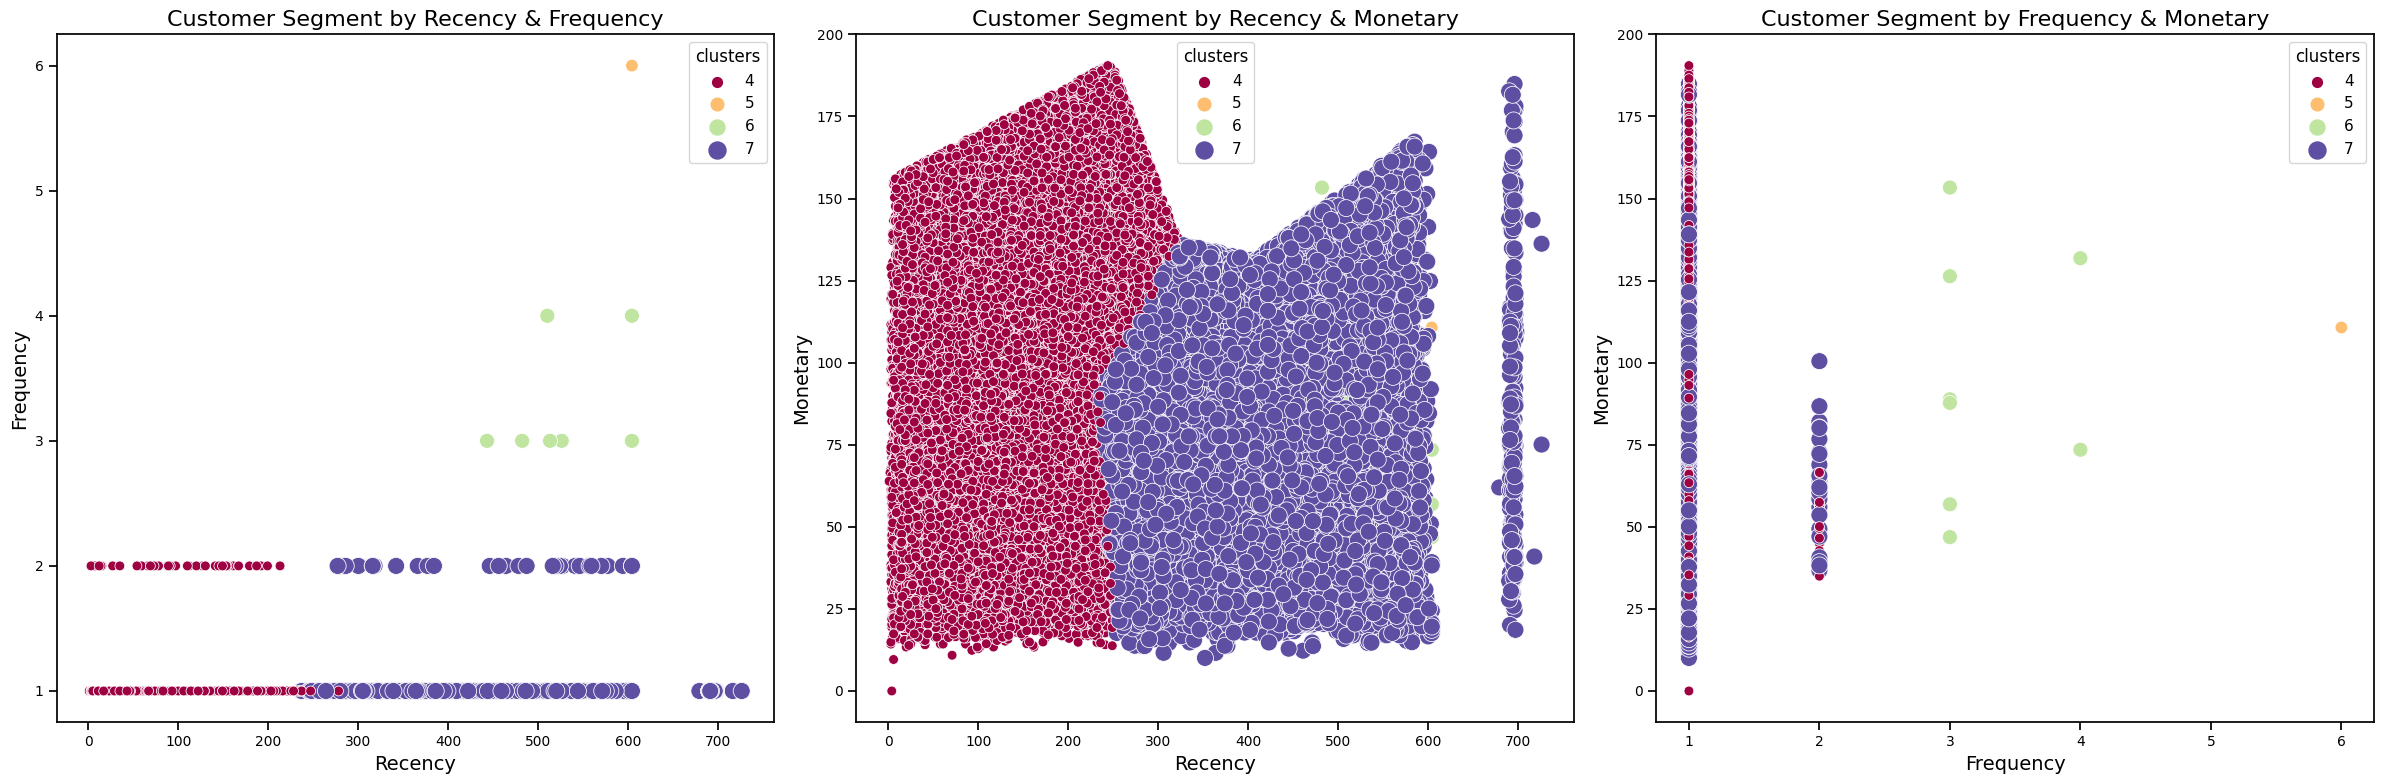

In [36]:
plot_rfm_segmentation(birch_segmentation[birch_segmentation["clusters"].isin([4,5,6,7])])

Visualisasi hasil clustering menggunakan algoritma BIRCH dengan jumlah cluster 8 dan threshold 0.7 terlihat sudah bisa membedakan segmen berdasarkan frekuensinya walaupun untuk kedua fitur lainnya banyak yang overlap atau tumpang tindih.

## **3.3 RFM Segmentation**

Tahapan segmentasi customer dengan analisis RFM (tanpa menggunakan model machine learning) adalah:
1. Membagi data ke dalam beberapa kelompok terurut  umumnya berdasarkan persentil masing-masing fitur (misal kuartil yang membagi data menjadi empat bagian) atau bisa juga berdasarkan nilai tertentu dari pemahaman domain knowledge.
2. Menggabungkan angka atau ranking masing-masing fitur untuk setiap data menjadi sebuah segmen RFM. Sebagai contoh, seorang customer mempunyai nilai Recency yang masuk ke kuartil ketiga atau mempunyai ranking 3, nilai Monetary di kuartil keempat atau mempunyai ranking 4, dan nilai Frequency di kuartil keempat juga atau ranking fitur frekuensi bernilai 4. Maka, segmen RFM untuk customer ini adalah 344.
3. Membuat kombinasi ranking masing-masing fitur untuk mengelompokkan segmen RFM berdasarkan referensi acuan ([akses di sini](https://documentation.bloomreach.com/engagement/docs/rfm-segmentation)).

Dalam analisis ini, ranking yang lebih tinggi akan menunjukkan perilaku customer yang lebih diinginkan.

Pada fitur Recency, nilai resensi yang lebih rendah menunjukkan perilaku customer yang lebih sesuai dengan harapan karena berarti waktu terakhir customer melakukan transaksi relatif cukup baru. Untuk itu, ranking lebih tinggi akan diberikan kepada customer dengan nilai resensi yang kecil. Sebaliknya, untuk fitur Monetary, nilai fitur sebanding dengan ranking yang diberikan karena semakin banyak pengeluaran customer, maka semakin besar nilai revenue perusahaan. Fitur Recency dan Monetary akan dibagi berdasarkan kuantilnya menjadi 5 segmen.

Pembagian fitur Frequency berbeda karena seperti yang telah dijelaskan pada EDA sebelumnya, 97% customer hanya melakukan transaksi satu kali saja. Dengan kata lain, frekuensi terpusat pada nilai 1 dan pembagian fitur berdasarkan nilai persentilnya akan menjadi kurang tepat. Pembagian segmen fitur Frequency akan dilakukan berdasarkan pemahaman domain knowledge. Melansir sebuah studi literatur ([akses di sini](https://www.trybeans.com/blog/analysis-of-loyalty-and-purchase-frequency-by-industry)) mengenai perilaku customer e-commerce secara frekuensi pembelian dan tingkat loyalitas, ditemukan bahwa customer loyal rata-rata melakukan pembelian barang 3-4 kali per tahunnya. Berhubung data yang digunakan dalam analisis ini adalah data customer Olist selama kurang lebih 2 tahun, maka rata-rata atau nilai tengah (kuantil ketiga) untuk segmen Frequency menjadi 6 kali per 2 tahun dan segmen kuantil kelima akan sebesar dua kali kuantil ketiga yaitu paling tidak melakukan pembelian sebanyak 12 kali per 2 tahun. Rentang kuantil sisanya akan disesuaikan. Nilai ranking yang lebih tinggi pada fitur Frequency diberikan pada nilai frekuensi yang juga lebih tinggi.

In [38]:
r_labels = range(5,0,-1)
r_quantiles = pd.qcut(rfm_data["recency"], 5, labels=r_labels)
rfm_data["R"] = r_quantiles.values

def segment_F(x):
    if x >= 12: return 5
    elif x >= 9: return 4
    elif x >= 6: return 3
    elif x >= 3: return 2
    else: return 1
rfm_data["F"] = rfm_data["frequency"].apply(segment_F)

m_labels = range(1,6)
m_quantiles = pd.qcut(rfm_data["monetary"], 5, labels=m_labels)
rfm_data["M"] = m_quantiles.values

rfm_data["RFM"] = rfm_data["R"].astype(str) + rfm_data["F"].astype(str) + rfm_data["M"].astype(str)

def RFM_segmentation(x):
    if x in [555, 554, 544, 545, 454, 455, 445] :
        return 'Champions'
    elif x in [543, 444, 435, 355, 354, 345, 344, 335] :
        return 'Loyal'
    elif x in [553, 551, 552, 541, 542, 533, 532, 531, 452, 451, 442, 441, 431, 453, 433, 432, 423, 353, 352, 351, 342, 341, 333, 323] :
        return 'Potential Loyalist'
    elif x in [512, 511, 422, 421, 412, 411, 311] :
        return 'New Customers'
    elif x in [525, 524, 523, 522, 521, 515, 514, 513, 425, 424, 413, 414, 415, 315, 314, 313] :
        return 'Promising'
    elif x in [535, 534, 443, 434, 343, 334, 325, 324] :
        return 'Need Attention'
    elif x in [331, 321, 312, 221, 213, 231, 241, 251] :
        return 'About To Sleep'
    elif x in [255, 254, 245, 244, 253, 252, 243, 242, 235, 234, 225, 224, 153, 152, 145, 143, 142, 135, 134, 133, 125, 124] :
        return 'At Risk'
    elif x in [155, 154, 144, 214,215,115, 114, 113] :
        return 'Cannot Lose Them'
    elif x in [332, 322, 233, 232, 223, 222, 132, 123, 122, 212, 211] :
        return 'Hibernating Customers'
    elif x in [111, 112, 121, 131, 141, 151] :
        return 'Lost Customers'

rfm_data['RFM_segment'] = rfm_data['RFM'].astype(int).apply(RFM_segmentation)
display(rfm_data["RFM_segment"].value_counts().reset_index())

rfm_data.to_csv("../data/model/rfm_data.csv", index=False)

RFM_segment  count
0               Promising  35060
1           New Customers  18861
2        Cannot Lose Them  18654
3          Lost Customers   8018
4   Hibernating Customers   7849
5          About To Sleep   7539
6                 At Risk     66
7          Need Attention     34
8                   Loyal      5
9      Potential Loyalist      3
10              Champions      1

### **3.3.1 Visualize Clusters**

<Figure size 2400x800 with 0 Axes>

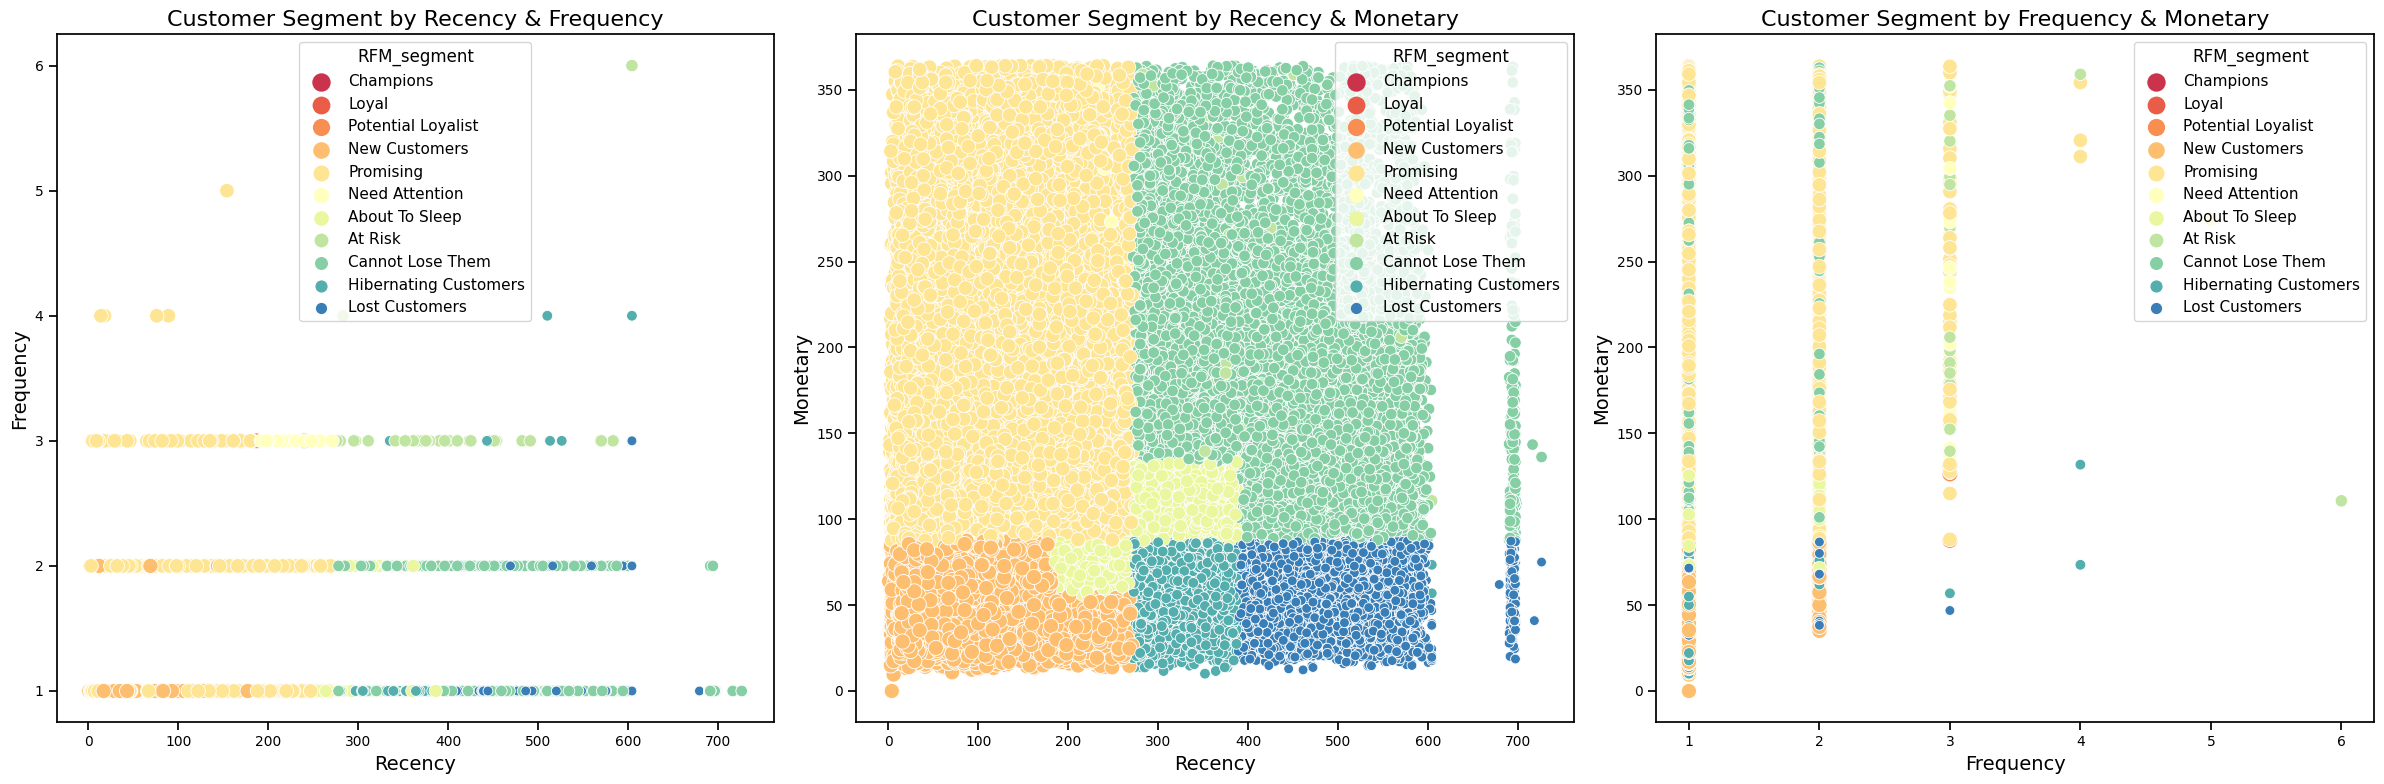

In [39]:
plt.figure(figsize=(24,8), facecolor='w')
segment = ['Champions', 'Loyal', 'Potential Loyalist', 'New Customers', 'Promising', 'Need Attention', 'About To Sleep', 'At Risk', 'Cannot Lose Them', 'Hibernating Customers', 'Lost Customers']

plot_rfm_segmentation(rfm_data[rfm_data["monetary"]<=monetary_upper_thres], hue='RFM_segment', size='RFM_segment', size_order=segment, hue_order=segment)

<Figure size 2400x800 with 0 Axes>

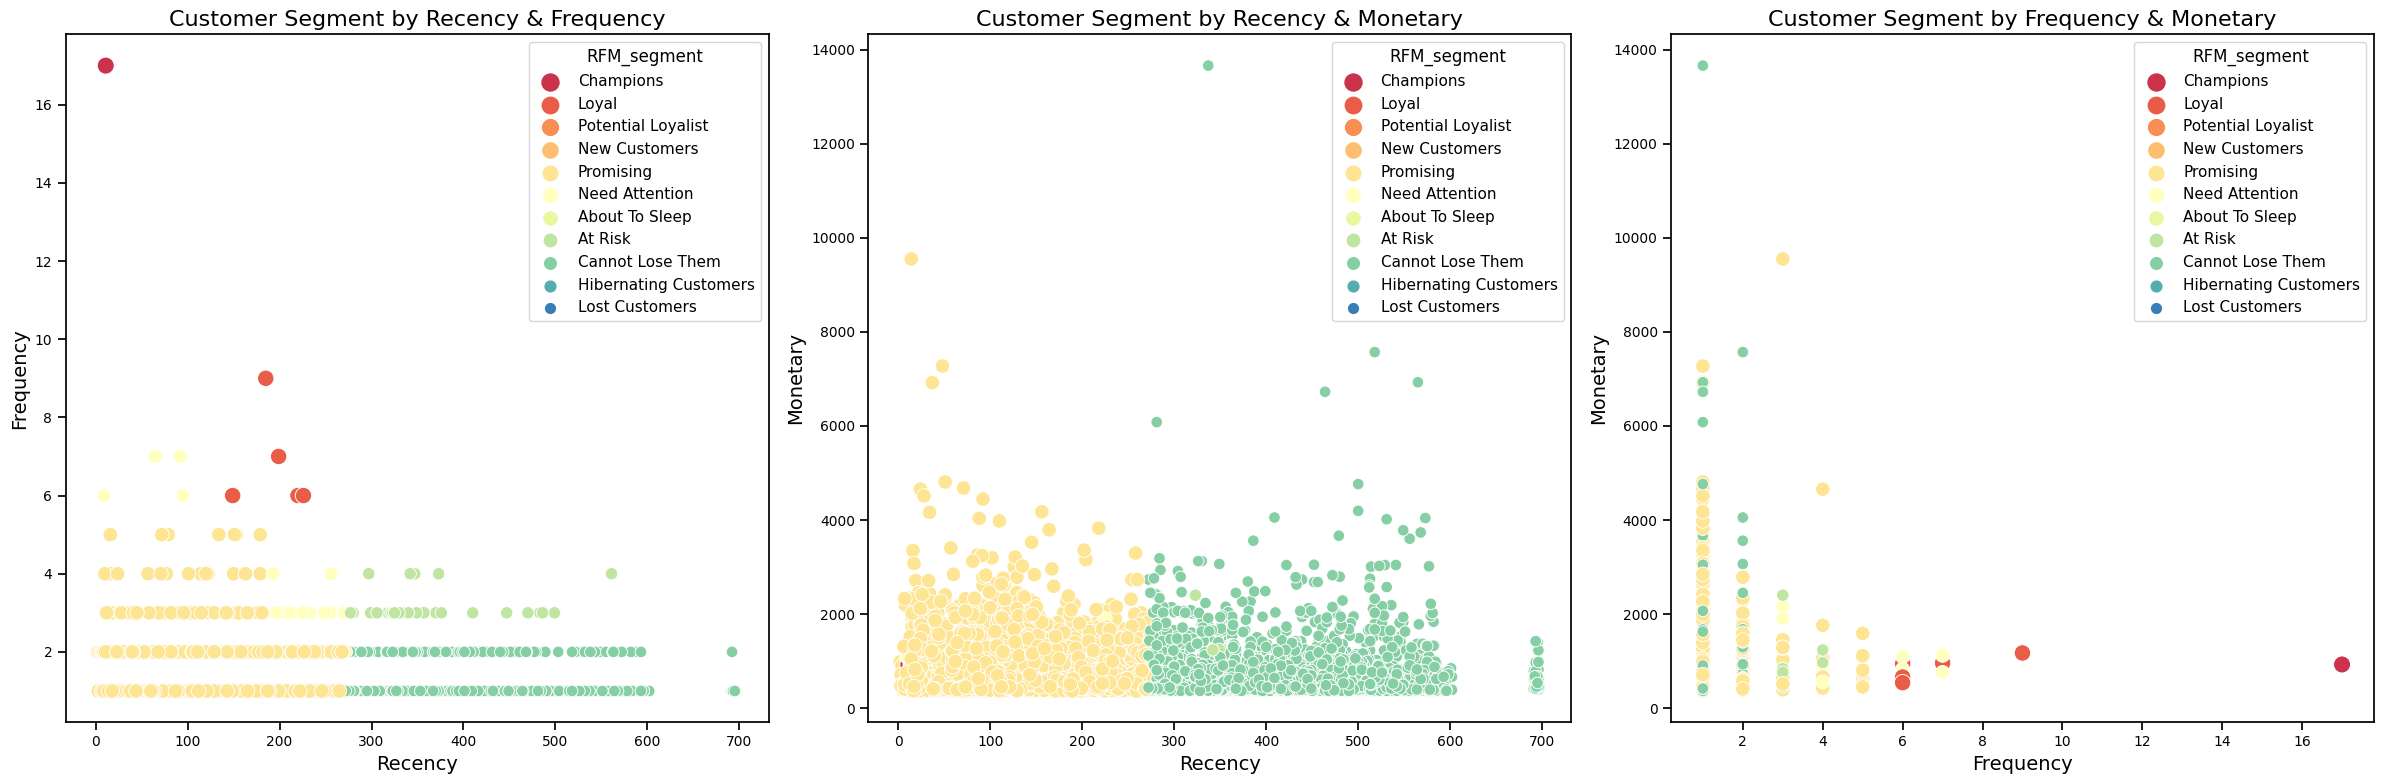

In [40]:
plt.figure(figsize=(24,8), facecolor='w')
segment = ['Champions', 'Loyal', 'Potential Loyalist', 'New Customers', 'Promising', 'Need Attention', 'About To Sleep', 'At Risk', 'Cannot Lose Them', 'Hibernating Customers', 'Lost Customers']
plot_rfm_segmentation(rfm_data[rfm_data["monetary"]>monetary_upper_thres], hue='RFM_segment', size='RFM_segment', size_order=segment, hue_order=segment)

Visualisasi hasil segmentasi RFM menunjukkan bahwa data baik yang merupakan outlier atau bukan bisa terbagi dengan cukup jelas untuk ketiga fiturnya.

In [41]:
def RFM_segmentation_score(x):
    if x == 'Champions':
        return 11
    elif x == 'Loyal':
        return 10
    elif x == 'Potential Loyalist':
        return 9
    elif x == 'New Customers':
        return 8
    elif x == 'Promising':
        return 7
    elif x == 'Need Attention':
        return 6
    elif x == 'About To Sleep':
        return 5
    elif x == 'At Risk':
        return 4
    elif x == 'Cannot Lose Them':
        return 3
    elif x == 'Hibernating Customers':
        return 2
    elif x == 'Lost Customers':
        return 1
    
tmp = rfm_data[rfm_data["monetary"] <= monetary_upper_thres].copy()
tmp['RFM_segment_score'] = tmp['RFM_segment'].apply(RFM_segmentation_score)

scaler = RobustScaler()
tmp_scaled = scaler.fit_transform(tmp[['recency', 'frequency', 'monetary']])
print(f"RFM Segmentation Silhouette score: {silhouette_score(tmp_scaled, tmp['RFM_segment_score'])}")
print(f"RFM Segmentation Davies Bouldin score: {davies_bouldin_score(tmp_scaled, tmp['RFM_segment_score'])}")

RFM Segmentation Silhouette score: 0.1817884727917369
RFM Segmentation Davies Bouldin score: 1.195502317464313


## **3.4 Summary**

* K-Means
    * Kelebihan:
        * Cara kerja model dan implementasi relatif mudah dipahami
        * Scalable untuk dataset berukuran besar
        * Waktu pemrosesan (training dan tuning) lebih cepat dibandingkan BIRCH
    * Kekurangan:
        * Hasil segmentasi belum bisa membedakan fitur frekuensi
* BIRCH
    * Kelebihan:
        * Scalable untuk dataset berukuran besar
        * Hasil segmentasi terlihat bisa membedakan fitur frekuensi
    * Kekurangan:
        * Cara kerja model dan implementasi relatif sulit dipahami
        * Waktu pemrosesan (training dan tuning) memerlukan paling lama
* RFM Segmentation
    * Kelebihan:
        * Implementasi dan segmentasi sangat mudah dipahami
        * Scalable untuk dataset berukuran besar
        * Waktu pemrosesan sangat cepat
        * Bisa mensegmentasi outlier
        * Interpretasi hasil segmentasi
    * Kekurangan:
        * Memiliki performa metrik evaluasi paling rendah jika dibandingkan K-Means dan BIRCH

| Aspek               | K-Means & Fitur RFM    | BIRCH & Fitur RFM     | Analisis RFM          |
| ------------------- | ---------------------- | --------------------- | --------------------- |
| Metrik Evaluasi     | Rendah                 | Rendah                | Rendah                |
| Waktu Pemrosesan    | Sedang                 | Tinggi                | Sangat Rendah         |
| Interpretasi        | Kurang Baik            | Kurang Baik           | Sangat Baik           |

Hasil segmentasi yang pada akhirnya dipilih adalah yang didapatkan menggunakan RFM Segmentation (bukan model machine learning) dengan pertimbangan metode ini memiliki interpretasi paling tinggi dan waktu pemrosesan paling cepat dibandingkan metode lainnya.